In [2]:
%run data_loader.py

Data loaded


## Step 1: Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.container import Container
import itertools
import math

In [4]:
file_base_name = "data/BBC News {}.csv"
test_data = pd.read_csv(file_base_name.format("Test"))
train_data = pd.read_csv(file_base_name.format("Train"))

In [5]:
print(train_data.info())
print(train_data.describe())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None
         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [6]:
print(test_data.info())
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [7]:
solution = pd.read_csv("data/BBC News Sample Solution.csv")
solution.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics


In [8]:
# Extracting labels
labels = train_data["Category"].unique().tolist()
labels

['business', 'tech', 'politics', 'sport', 'entertainment']

In [9]:
train_data.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

In [10]:
def remove_0_tags_for_histograms(ax_container:Container):
    ind = np.where(ax_container.datavalues>0)[0]    
    ax_container.datavalues = ax_container.datavalues[ind]
    ax_container.patches = [ax_container.patches[i] for i in ind]
    return ax_container

def add_histogram_values(ax:plt.Axes):
    [ax.bar_label(remove_0_tags_for_histograms(b)) for b in ax.containers]

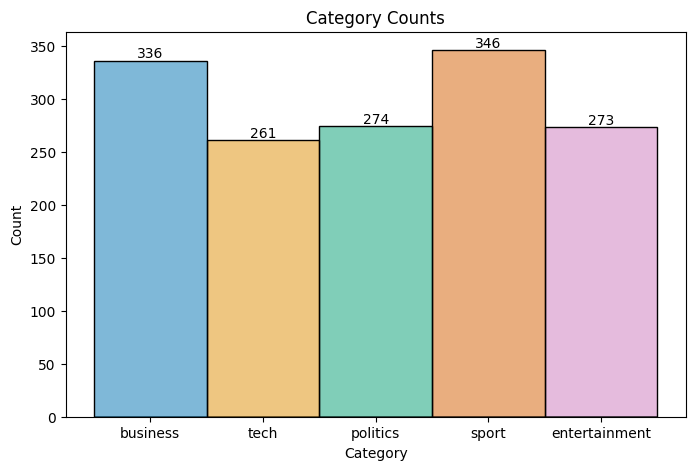

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
ax2 = sns.histplot(
    data = train_data,
    x = 'Category',
    hue = 'Category',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Category Counts')

add_histogram_values(ax)

In [12]:
train_data['text multiplicity'] = train_data.groupby('Text')['Text'].transform('count').astype(str) 


C:\Users\OM-FI\AppData\Local\Temp\ipykernel_33068\2609365779.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax2 = sns.histplot(


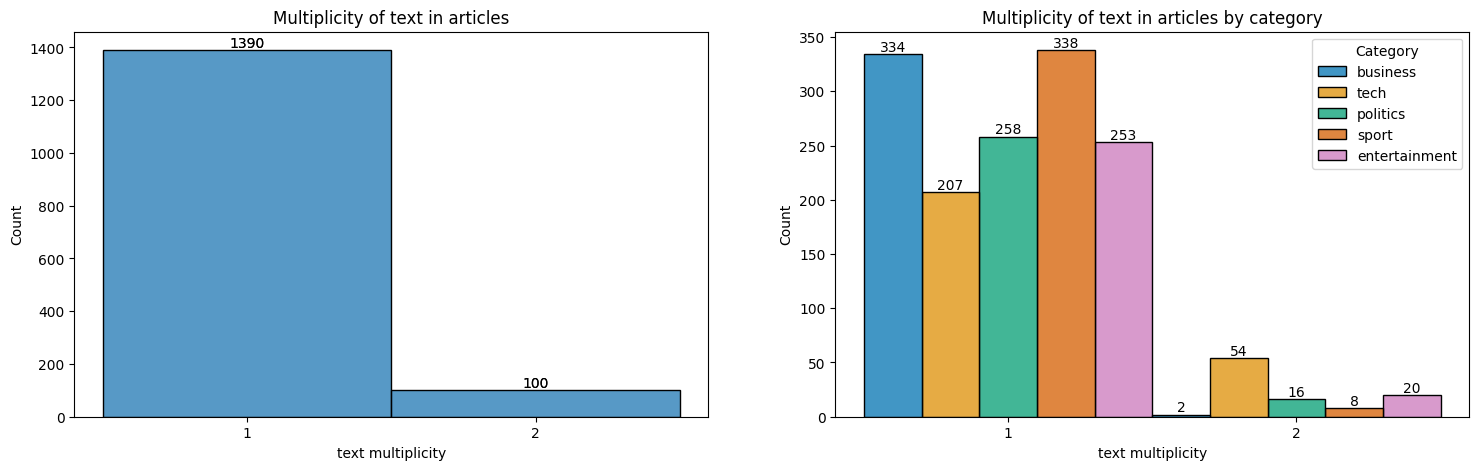

In [13]:
fig, ax = plt.subplots(ncols=2,figsize=(18, 5))

# Histogram showing repeated text multiplicity in training dataframe
ax2 = sns.histplot(
    ax = ax[0],
    data = train_data,
    x='text multiplicity',
    palette = 'colorblind',
    multiple = 'dodge',
    legend = True,
    ).set(
        title = 'Multiplicity of text in articles')
add_histogram_values(ax[0])
# Same histogram, by Category
ax2 = sns.histplot(
    ax = ax[1],
    data = train_data,
    x='text multiplicity',
    hue = 'Category',
    palette = 'colorblind',
    multiple = 'dodge',
    legend = True,
    ).set(
        title = 'Multiplicity of text in articles by category')
add_histogram_values(ax[0])
add_histogram_values(ax[1])

In [14]:
# Check how many categories are in each repeated text group
print(train_data[train_data['text multiplicity']!='1'].groupby('Text', as_index=False)['Category'].nunique().head())
print("--"*30,"\n")
print('The maximum number of different categories assigned to repeated texts is: {}'.format(\
train_data[train_data['text multiplicity']!='1'].groupby('Text')['Category'].nunique().max()))

                                                Text  Category
0  ask jeeves joins web log market ask jeeves has...         1
1  aviator  creator  in oscars snub the man who s...         1
2  blind student  hears in colour  a blind studen...         1
3  bortolami predicts dour contest italy skipper ...         1
4  britons fed up with net service a survey condu...         1
------------------------------------------------------------ 

The maximum number of different categories assigned to repeated texts is: 1


## Cleaning data

In [74]:
import re

def show_special_words(text:str):
    print("Money format")
    print(re.findall(r'[\$\£\€\¥]\d+(?:\.\d+)?[a-zA-Z]*',text))
    print("Number format")
    print(set(re.findall(r'\s(\d+(?:[\.\s]\d+)?)(?![%])', text)))
    print("Percentage format")
    print(set(re.findall(r'\b(\d+(?:\.\d+)?%)',text)))
    print("Non alpha-numeric symbols")
    print(set(re.findall(r'[^a-zA-Z0-9 ]', text)))

print('*'*40)
print('Sample text:')
print(train_data['Text'][0])
print('*'*40)
print('Special "words":')
print('-'*40)
show_special_words(train_data['Text'][0])

****************************************
Sample text:
worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to 

In [77]:
for i in range(3): show_special_words(train_data["Text"][i])

Money format
['$11bn', '£5.7bn', '$6.75bn']
Number format
{'85', '2001', '2002', '2004'}
Percentage format
set()
Non alpha-numeric symbols
{'-', ')', '$', '.', '£', '('}
Money format
[]
Number format
{'1', '97.5', '2004', '95.5', '2003', '0'}
Percentage format
{'0.2%', '1.6%', '10%', '2%'}
Non alpha-numeric symbols
{'.', '%', '-'}
Money format
[]
Number format
{'23 000', '22', '2005', '2001', '13', '5', '2.5', '22 953', '2004', '4', '14', '3', '15'}
Percentage format
{'34%', '48%', '47%', '41%', '36%', '44%'}
Non alpha-numeric symbols
{')', '-', '.', '(', ':', '%'}


## Step 2: Building and training models